In [133]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
%matplotlib inline

# Read in the data, reading in a few columns as datetime objects
tbl = pd.read_pickle('data/data_augmented.pkl')
NUM_GENRE = len(tbl['genre'].value_counts())

9


In [2]:
# Take a look at the columns and their data types
print "Columns:"
for col in tbl.columns.tolist():
    print "\t%16s" % col + " : " + str(tbl[col].dtype)

Columns:
	     UMS_acct_no : int64
	    acct_created : datetime64[ns]
	       cust_type : object
	       perf_name : object
	         perf_dt : datetime64[ns]
	         tck_amt : float64
	       num_seats : int64
	           venue : object
	      price_type : object
	price_type_group : object
	    mode_of_sale : object
	   sales_channel : object
	        order_dt : datetime64[ns]
	     postal_code : object
	           genre : object
	     description : object


In [3]:
# Each row corresponds to a single transaction
print tbl.head()

   UMS_acct_no acct_created  cust_type             perf_name  \
0         1111   1979-08-06  Household   The Infernal Comedy   
1         1111   1979-08-06  Household      Yuja Wang, piano   
2         1111   1979-08-06  Household   London Philharmonic   
3         1111   1979-08-06  Household      Hamburg Symphony   
4         1111   1979-08-06  Household  Chicago Symphony Orc   

              perf_dt  tck_amt  num_seats            venue    price_type  \
0 2011-10-01 20:00:00    112.0          2  Hill Auditorium  Choral Union   
1 2011-10-09 16:00:00     80.0          2  Hill Auditorium  Choral Union   
2 2011-12-06 19:30:00    112.0          2  Hill Auditorium  Choral Union   
3 2012-01-29 16:00:00     92.0          2  Hill Auditorium  Choral Union   
4 2012-03-09 20:00:00    140.0          2  Hill Auditorium  Choral Union   

  price_type_group  mode_of_sale sales_channel   order_dt postal_code  \
0      Subs Prices  Subscription           Fax 2011-05-31       48103   
1      Subs 

In [4]:
# From this table we can derive an account-level table

acc_tbl = tbl[['UMS_acct_no', 'acct_created', 'cust_type']]
acc_tbl = acc_tbl.drop_duplicates()
acc_tbl = acc_tbl.set_index('UMS_acct_no')

print acc_tbl.head()

            acct_created  cust_type
UMS_acct_no                        
1111          1979-08-06  Household
1115          1988-02-18  Household
1122          1988-02-10  Household
1130          1988-02-26  Household
1131          1988-02-26  Household


In [41]:
(tbl[tbl['UMS_acct_no'] == 1111].sort_values(by='order_dt')['mode_of_sale'].values == 'Subscription').nonzero()[0][0]

0

In [6]:
# We can aggregate some purchase-level statistics for each account

grpAcct = tbl.groupby('UMS_acct_no')

In [7]:
acc_tbl['num_purchases']        = grpAcct['acct_created'].count() # any var works here, just need the count
acc_tbl['first_purchase']       = grpAcct['perf_dt'].min()
acc_tbl['most_recent_purchase'] = grpAcct['perf_dt'].max()
acc_tbl['total_purchase_amt']   = grpAcct['tck_amt'].sum()
acc_tbl['max_purchase_amt']     = grpAcct['tck_amt'].max()
acc_tbl['avg_purchase_amt']     = grpAcct['tck_amt'].mean()
acc_tbl['total_num_seats']      = grpAcct['num_seats'].sum()
acc_tbl['max_num_seats']        = grpAcct['num_seats'].max()
acc_tbl['med_num_seats']        = grpAcct['num_seats'].median()
acc_tbl['avg_seat_amt']         = grpAcct['tck_amt'].sum() / grpAcct['num_seats'].sum()
acc_tbl['subscriber']  = grpAcct['mode_of_sale'].agg(lambda x : x.eq('Subscription').any())

acc_tbl.head()

,acct_created,cust_type,num_purchases,first_purchase,most_recent_purchase,total_purchase_amt,max_purchase_amt,avg_purchase_amt,total_num_seats,max_num_seats,med_num_seats,avg_seat_amt,subscriber
UMS_acct_no,,,,,,,,,,,,,
1111,1979-08-06,Household,29,2011-10-01 20:00:00,2014-04-13 16:00:00,3008.0,150.0,103.724138,55,2,2.0,54.690909,True
1115,1988-02-18,Household,33,2011-10-01 20:00:00,2014-04-13 16:00:00,4066.0,184.0,123.212121,61,2,2.0,66.655738,True
1122,1988-02-10,Household,1,2012-09-27 19:30:00,2012-09-27 19:30:00,200.0,200.0,200.000000,2,2,2.0,100.000000,False
1130,1988-02-26,Household,8,2012-02-18 20:00:00,2013-12-08 14:00:00,652.0,130.0,81.500000,15,2,2.0,43.466667,False
1131,1988-02-26,Household,20,2011-10-01 20:00:00,2013-04-20 20:00:00,2616.0,182.0,130.800000,40,2,2.0,65.400000,True


In [93]:
# get subscriber info

subs = acc_tbl[acc_tbl['subscriber'] == True]

# get number of shows before person became subscriber
conv_map = dict()
conv_genre_map = dict()
for acc_no in subs.index:
    # get index of first show that was ordered under subscription
    conv_index = (tbl[tbl['UMS_acct_no'] == acc_no].sort_values(by='order_dt')['mode_of_sale'].values == 'Subscription').nonzero()[0][0]
    conv_map[acc_no] = conv_index
    # get genre of show right before conversion
    if conv_index > 0:
        conv_genre = tbl[tbl['UMS_acct_no'] == acc_no].sort_values(by='order_dt')['genre'].iloc[conv_index-1]
        conv_genre_map[acc_no] = conv_genre
subs['shows_before_conversion'] = pd.Series(conv_map)
subs['genre_before_conversion'] = pd.Series(conv_genre_map)

subs.head()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,acct_created,cust_type,num_purchases,first_purchase,most_recent_purchase,total_purchase_amt,max_purchase_amt,avg_purchase_amt,total_num_seats,max_num_seats,med_num_seats,avg_seat_amt,subscriber,shows_before_conversion,genre_before_conversion
UMS_acct_no,,,,,,,,,,,,,,,
1111,1979-08-06,Household,29,2011-10-01 20:00:00,2014-04-13 16:00:00,3008.0,150.0,103.724138,55,2,2.0,54.690909,True,0,NaN
1115,1988-02-18,Household,33,2011-10-01 20:00:00,2014-04-13 16:00:00,4066.0,184.0,123.212121,61,2,2.0,66.655738,True,0,NaN
1131,1988-02-26,Household,20,2011-10-01 20:00:00,2013-04-20 20:00:00,2616.0,182.0,130.800000,40,2,2.0,65.400000,True,0,NaN
1143,1988-02-10,Individual,48,2011-10-09 16:00:00,2014-04-13 16:00:00,2580.6,100.0,53.762500,49,2,1.0,52.665306,True,14,theatre
1152,1988-02-10,Individual,16,2011-09-18 16:00:00,2013-11-03 16:00:00,1034.0,91.0,64.625000,16,1,1.0,64.625000,True,4,orchestral


In [169]:
subs_prop = len(subs) / len(acc_tbl)
subs_purc = subs['total_purchase_amt'].sum() / acc_tbl['total_purchase_amt'].sum()

subs_recent = subs[subs['acct_created'] >= tbl['order_dt'].min()]
subs_prop_convs = len(subs_recent[subs_recent['shows_before_conversion'] > 0]) / len(subs_recent)

print "Percentage of accounts that are subscribers: ", 100 * subs_prop
print "Percentage of revenue from subscribers:      ", 100 * subs_purc
print "Percentage of subscribers who converted:     ", 100 * subs_prop_convs

Percentage of accounts that are subscribers:  5.02885408079
Percentage of revenue from subscribers:       40.9106000925
Percentage of subscribers who converted:      28.125


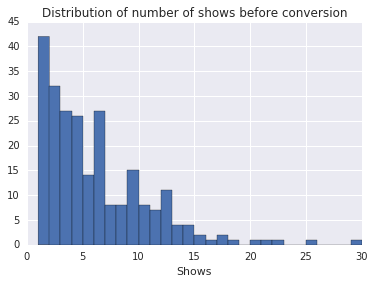

In [164]:
# How many shows did people go to before becoming a subscriber?

plt.hist(subs[subs['shows_before_conversion'] > 0]['shows_before_conversion'], bins=subs['shows_before_conversion'].max()-1)
plt.title('Distribution of number of shows before conversion')
plt.xlabel('Shows')

#plt.savefig('shows_before_conversion.png')
plt.show()

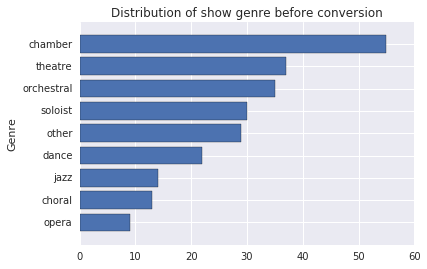

In [165]:
# What kind of show did people watch right before becoming a subscriber?

plt.barh(range(NUM_GENRE), subs['genre_before_conversion'].value_counts(ascending=True).values,
        align='center',
        tick_label=subs['genre_before_conversion'].value_counts(ascending=True).index)
plt.title('Distribution of show genre before conversion')
plt.ylabel('Genre')

#plt.savefig('show_genre_before_conversion.png')
plt.show()